# Analysis for Figure2c

In [11]:
1

1

In [2]:
import copy
import gc
import os
import sys
import warnings
import time
import importlib
import subprocess

import anndata as ad
import networkx as nx
import numpy as np
import pandas as pd
import scanpy as sc
import torch

sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
import tardis

tardis.config = tardis.config_server
sc.settings.verbosity = 3

print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: True


In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [5]:
n_reserved_latent = 8
n_unreserved_latent = 24

dataset_handles = {
    "Suo": {"models": {
        "scvi": {'suo': dict()},
        "tardis": {
            "suo_v01_01": {"targets": ["integration_donor", "integration_library_platform_coarse", "organ"]},  # order is important
            "suo_v01_02": {"targets": ["organ"]},  # order is important
            "suo_v01_03": {"targets": ["integration_donor", "organ"]},  # order is important
            "suo_v01_04": {"targets": ["integration_library_platform_coarse", "organ"]},  # order is important
            "suo_v01_05": {"targets": []},  # order is important
            "suo_v02_01": {"targets": ["integration_library_platform_coarse"]},  # order is important
            "suo_v02_02": {"targets": ["integration_donor", "integration_library_platform_coarse"]},  # order is important
            "suo_v02_03": {"targets": ["integration_donor"]},  # order is important
            "suo_v02_04": {"targets": []},  # order is important
        }, 
    }},
}

In [ ]:
# n_reserved_latent = 8
# n_unreserved_latent = 24

# dataset_handles = {
#     "Kanemaru": {"models": {
#         "scvi": {'kanemaru': dict()}, 
#         "tardis": {
#             "kanemaru_sex_age_unit": {
#                 "targets": ["age", "sex", "integration_biological_unit"] # order is important
#             }
#         }, 
#     }}, 
#     "Braun": {"models": {
#         "scvi": {'braun': dict()}, 
#         "tardis": {
#             "braun_sex_age": {
#                 "targets": ["age", "sex"]  # order is important
#             }
#         }, 
#     }},
#     "Suo": {"models": {
#         "scvi": {'suo': dict()},
#         "tardis": {
#             "suo_age": {"targets": ["age"]},  # order is important
#             "suo_sex": {"targets": ["sex"]},  # order is important
#             "suo_organ": {"targets": ["organ"]},  # order is important
#             "suo_platform": {"targets": ["platform"]},  # order is important
#             "suo_sex_age_organ_platform": {"targets": ["age", "sex", "integration_library_platform_coarse", "organ"]},  # order is important
#         }, 
#     }},
#     "Miller": {"models": {
#         "scvi": {'miller': dict()}, 
#         "tardis": {
#             "miller_age": {"targets": ["age"]}, # order is important
#             "miller_sex": {"targets": ["sex"]}, # order is important
#             "miller_sex_age": {"targets": ["age", "sex"]}, # order is important
#         }, 
#     }},
#     "He": {"models": {
#         "scvi": {'he': dict()}, 
#         "tardis": {
#             "he_sex_age": {"targets": ["age", "sex"]} # order is important
#         }, 
#     }},
#     "Garcia": {"models": {
#         "scvi": {'garcia': dict()}, 
#         "tardis": {
#             "garcia_sex_age_status": {"targets": ["age", "sex", "integration_sample_status"]} # order is important
#         }, 
        
#     }},
# }

In [6]:
k_neighbours = [15, 30]
for handle in dataset_handles:
    adata_dir = os.path.join(tardis.config.io_directories["processed"], f"dataset_complete_{handle}.h5ad")
    dataset_handles[handle]["adata_dir"] = adata_dir
    for model_type in dataset_handles[handle]["models"]:
        for model_name in dataset_handles[handle]["models"][model_type]:
            model_dir = os.path.join(tardis.config.io_directories["models"], model_name)
            dataset_handles[handle]["models"][model_type][model_name]["model_dir"] = model_dir
            dataset_handles[handle]["models"][model_type][model_name]["latent_dir"] = {i: dict() for i in k_neighbours}
            for n_neighbors in k_neighbours:
                latent_dir = os.path.join(tardis.config.io_directories["temp"], "latent", f"{model_name}_{model_type}_{n_neighbors}_latent.h5ad")
                dataset_handles[handle]["models"][model_type][model_name]["latent_dir"][n_neighbors] = latent_dir
            if model_type == "tardis":
                targets = dataset_handles[handle]["models"][model_type][model_name]["targets"]
                dataset_handles[handle]["models"][model_type][model_name]["targets_latent"] = {i: list(range(8 * ind, 8 * (ind+1))) for ind, i in enumerate(targets)}
                dataset_handles[handle]["models"][model_type][model_name]["targets_latent"]["unreserved"] = list(range(len(targets) * 8, (3 + len(targets)) * 8 ))

In [7]:
args_list = []

for handle in dataset_handles:
    for model_type in dataset_handles[handle]["models"]:
        for model_name in dataset_handles[handle]["models"][model_type]:
            for n_neighbors in dataset_handles[handle]["models"][model_type][model_name]["latent_dir"]:
                if model_type == "tardis":
                    _helper = [(k, v) for k, v in dataset_handles[handle]["models"][model_type][model_name]["targets_latent"].items()]
                
                args_list.append([
                    dataset_handles[handle]["adata_dir"],  # adata_dir, 
                    dataset_handles[handle]["models"][model_type][model_name]["model_dir"],  # model_dir, 
                    dataset_handles[handle]["models"][model_type][model_name]["latent_dir"][n_neighbors],  # latent_dir, 
                    str(n_neighbors),  # n_neighbors, 
                    model_name, # model_name, 
                    model_type,  # model_type
                    "placeholder" if model_type != "tardis" else ".".join([k for k, v in _helper]),  # target_ids
                    "placeholder" if model_type != "tardis" else ".".join([','.join([str(i) for i in v]) for k, v in _helper]),  # target_reserves
                ])

### Read the model and get the latent

In [9]:
for args in args_list:
    data_dir, model_dir, output_dir, n_neighbors, model_name, model_type, target_ids, target_reserves = args
    print(model_type, model_name, n_neighbors)

    # Check if output directory does not exist and model directory does exist
    if os.path.exists(output_dir):
        print(f"Latent is calculated already: `{model_name, n_neighbors}`")
    
    elif not os.path.exists(model_dir):
        print(f"Model is not there: `{model_name}`")
    
    elif not os.path.exists(output_dir) and os.path.exists(model_dir):
        # Generate the Slurm script
        slurm_script = f"""#!/bin/bash

#SBATCH -J tardis_latent_run
#SBATCH -p gpu_p
#SBATCH --qos=gpu_normal
#SBATCH --gres=gpu:1
#SBATCH -c 6
#SBATCH --mem=159G
#SBATCH --nice=0
#SBATCH -t 1-23:50:00

source activate tardis_env
python /home/icb/kemal.inecik/work/codes/tardis/notebooks/figure2c/collect_latent.py {data_dir} {model_dir} {output_dir} {n_neighbors}
"""

        # Save the script to a temporary file
        script_file = os.path.join(os.getcwd(), f"slurm_job_{model_name}_{n_neighbors}.sh")
        with open(script_file, "w") as file:
            file.write(slurm_script)

        # Submit the Slurm job
        subprocess.run(["sbatch", script_file])
        # subprocess.run(["rm", "-rf", script_file])

    else:
        raise ValueError

scvi suo 15
Latent is calculated already: `('suo', '15')`
scvi suo 30
Latent is calculated already: `('suo', '30')`
tardis suo_v01_01 15
Model is not there: `suo_v01_01`
tardis suo_v01_01 30
Model is not there: `suo_v01_01`
tardis suo_v01_02 15
Submitted batch job 20303133
tardis suo_v01_02 30
Submitted batch job 20303134
tardis suo_v01_03 15
Submitted batch job 20303135
tardis suo_v01_03 30
Submitted batch job 20303136
tardis suo_v01_04 15
Submitted batch job 20303137
tardis suo_v01_04 30
Submitted batch job 20303138
tardis suo_v01_05 15
Submitted batch job 20303139
tardis suo_v01_05 30
Submitted batch job 20303140
tardis suo_v02_01 15
Submitted batch job 20303141
tardis suo_v02_01 30
Submitted batch job 20303142
tardis suo_v02_02 15
Submitted batch job 20303143
tardis suo_v02_02 30
Submitted batch job 20303144
tardis suo_v02_03 15
Submitted batch job 20303145
tardis suo_v02_03 30
Submitted batch job 20303146
tardis suo_v02_04 15
Submitted batch job 20303147
tardis suo_v02_04 30
Submi

### Get each sublatent combos

In [12]:
for args in args_list:
    data_dir, model_dir, latent_dir, n_neighbors, model_name, model_type, target_ids, target_reserves = args
    
    if model_type != "tardis":
        continue
    
    print(model_type, model_name, n_neighbors)

    # Check if output directory does not exist and model directory does exist
    if not os.path.exists(latent_dir):
        print(f"Latent is not yet calculated: `{model_name, n_neighbors}`")
        continue

    a_ = ad.read_h5ad(latent_dir, backed='r')
    if "tardis_subsets" in a_.uns:
        print(f"sublatents are already calculated: `{model_name, n_neighbors}`")
    
    else:
        # Generate the Slurm script
        slurm_script = f"""#!/bin/bash

#SBATCH -J tardis_latent_run2
#SBATCH -p gpu_p
#SBATCH --qos=gpu_normal
#SBATCH --gres=gpu:1
#SBATCH -c 6
#SBATCH --mem=99G
#SBATCH --nice=0
#SBATCH -t 1-23:50:00

source activate tardis_env
python /home/icb/kemal.inecik/work/codes/tardis/notebooks/figure2c/append_sublatents.py {latent_dir} {target_ids} {target_reserves} {n_neighbors}
"""

        # Save the script to a temporary file
        script_file = os.path.join(os.getcwd(), f"slurm_job_{model_name}_{n_neighbors}_append.sh")
        with open(script_file, "w") as file:
            file.write(slurm_script)

        # Submit the Slurm job
        subprocess.run(["sbatch", script_file])
        # subprocess.run(["rm", "-rf", script_file])
    
    del a_
    gc.collect()

tardis suo_v01_01 15
Latent is not yet calculated: `('suo_v01_01', '15')`
tardis suo_v01_01 30
Latent is not yet calculated: `('suo_v01_01', '30')`
tardis suo_v01_02 15
Submitted batch job 20303284
tardis suo_v01_02 30
Submitted batch job 20303285
tardis suo_v01_03 15
Submitted batch job 20303286
tardis suo_v01_03 30
Submitted batch job 20303287
tardis suo_v01_04 15
Submitted batch job 20303288
tardis suo_v01_04 30
Submitted batch job 20303289
tardis suo_v01_05 15
Submitted batch job 20303290
tardis suo_v01_05 30
Submitted batch job 20303291
tardis suo_v02_01 15
Submitted batch job 20303292
tardis suo_v02_01 30
Submitted batch job 20303293
tardis suo_v02_02 15
Submitted batch job 20303294
tardis suo_v02_02 30
Submitted batch job 20303295
tardis suo_v02_03 15
Submitted batch job 20303296
tardis suo_v02_03 30
Submitted batch job 20303297
tardis suo_v02_04 15
Submitted batch job 20303298
tardis suo_v02_04 30
Submitted batch job 20303299


In [10]:
# for i in args_list:
#     print(os.path.split(i[2])[1])

In [11]:
# # !ls -lh /lustre/groups/ml01/workspace/kemal.inecik/tardis_data/temp/latent/*_subset-*.h5ad
# !rm -rf /lustre/groups/ml01/workspace/kemal.inecik/tardis_data/temp/latent/*_subset-*.h5ad

In [12]:
# !ls -lh /lustre/groups/ml01/workspace/kemal.inecik/tardis_data/temp/latent/

In [13]:
harmony_training = list({i[0] for i in args_list})
for harmony_training_adata in harmony_training:
    file_name = os.path.split(harmony_training_adata)[1]
    file_name_raw = os.path.splitext(file_name)[0]
    
    print(file_name_raw)
    a_ = ad.read_h5ad(harmony_training_adata, backed='r')

    if 'harmony' in a_.obsm.keys():
        print(f"Harmony already calculated: `{file_name_raw}`")

    else:
        # Generate the Slurm script
        slurm_script = f"""#!/bin/bash

#SBATCH -J tardis_harmony
#SBATCH -p cpu_p
#SBATCH --qos cpu_normal
#SBATCH -c 8
#SBATCH --mem=120G
#SBATCH --nice=0
#SBATCH -t 1-23:50:00

source activate tardis_env
python /home/icb/kemal.inecik/work/codes/tardis/notebooks/figure2c/integrate_harmony.py {harmony_training_adata}
"""

        # Save the script to a temporary file
        script_file = os.path.join(os.getcwd(), f"slurm_job_{file_name_raw}_harmony.sh")
        with open(script_file, "w") as file:
            file.write(slurm_script)

        # Submit the Slurm job
        subprocess.run(["sbatch", script_file])
        # subprocess.run(["rm", "-rf", script_file])
    
    del a_
    gc.collect()

dataset_complete_Miller
Harmony already calculated: `dataset_complete_Miller`
dataset_complete_Kanemaru
Harmony already calculated: `dataset_complete_Kanemaru`
dataset_complete_Suo
Harmony already calculated: `dataset_complete_Suo`
dataset_complete_Garcia
Harmony already calculated: `dataset_complete_Garcia`
dataset_complete_Braun
Harmony already calculated: `dataset_complete_Braun`
dataset_complete_He
Harmony already calculated: `dataset_complete_He`


In [14]:
only_neighbour = {
    30: "bioconservation",
    15: "batchcorrection"
}

for args in args_list:
    data_dir, model_dir, latent_dir, n_neighbors, model_name, model_type, target_ids, target_reserves = args

    metrics = only_neighbour[int(n_neighbors)]
    print(model_type, model_name, n_neighbors, metrics)
    # do it to prevent clash, then combine the calculations in the next cells 

    p1, p2 = os.path.splitext(latent_dir)
    p = p1 + f"_scib_{metrics}.pickle"
    
    # Check if output directory does not exist and model directory does exist
    if not os.path.exists(latent_dir):
        print(f"Latent is not yet calculated: `{model_name, metrics}`")
        continue

    if model_type != "scvi" and "unreserved" not in target_ids:
        print(f"tardis latent does not have unreserved: `{model_name, metrics}`")
        continue

    if os.path.exists(p):
        print(f"metrics already calculated: `{model_name, metrics}`")
        _ = pd.read_pickle(p)
    
    else:
        # Generate the Slurm script
        slurm_script = f"""#!/bin/bash

#SBATCH -J tardis_scib
#SBATCH -p cpu_p
#SBATCH --qos cpu_normal
#SBATCH -c 32
#SBATCH --mem=180G
#SBATCH --nice=0
#SBATCH -t 2-23:50:00

source activate tardis_env
python /home/icb/kemal.inecik/work/codes/tardis/notebooks/figure2c/calculate_scib.py {latent_dir} {model_type} {metrics} {target_ids} {target_reserves} {data_dir}
"""

        # Save the script to a temporary file
        script_file = os.path.join(os.getcwd(), f"slurm_job_{model_name}_{n_neighbors}_scib.sh")
        with open(script_file, "w") as file:
            file.write(slurm_script)

        # Submit the Slurm job
        # subprocess.run(["sbatch", script_file])
        # subprocess.run(["rm", "-rf", script_file])


scvi kanemaru 15 batchcorrection
metrics already calculated: `('kanemaru', 'batchcorrection')`
scvi kanemaru 30 bioconservation
metrics already calculated: `('kanemaru', 'bioconservation')`
tardis kanemaru_sex_age_unit 15 batchcorrection
metrics already calculated: `('kanemaru_sex_age_unit', 'batchcorrection')`
tardis kanemaru_sex_age_unit 30 bioconservation
metrics already calculated: `('kanemaru_sex_age_unit', 'bioconservation')`
scvi braun 15 batchcorrection
metrics already calculated: `('braun', 'batchcorrection')`
scvi braun 30 bioconservation
tardis braun_sex_age 15 batchcorrection
tardis braun_sex_age 30 bioconservation
scvi suo 15 batchcorrection
metrics already calculated: `('suo', 'batchcorrection')`
scvi suo 30 bioconservation
metrics already calculated: `('suo', 'bioconservation')`
tardis suo_age 15 batchcorrection
metrics already calculated: `('suo_age', 'batchcorrection')`
tardis suo_age 30 bioconservation
metrics already calculated: `('suo_age', 'bioconservation')`
tardi

calculate scib metrics:
create a sql database with the metrics

latent_dir, batch_key, label_key, metric

- scvi
- tardis
    - unreserved bioconservation and batch-correction (cell-type)
    - reserved batch

In [16]:
!ls /lustre/groups/ml01/workspace/kemal.inecik/tardis_data/_temporary/latent/*.pickle

/lustre/groups/ml01/workspace/kemal.inecik/tardis_data/_temporary/latent/braun_scvi_15_latent_scib_batchcorrection.pickle
/lustre/groups/ml01/workspace/kemal.inecik/tardis_data/_temporary/latent/garcia_scvi_15_latent_scib_batchcorrection.pickle
/lustre/groups/ml01/workspace/kemal.inecik/tardis_data/_temporary/latent/garcia_scvi_30_latent_scib_bioconservation.pickle
/lustre/groups/ml01/workspace/kemal.inecik/tardis_data/_temporary/latent/garcia_sex_age_status_tardis_15_latent_scib_batchcorrection.pickle
/lustre/groups/ml01/workspace/kemal.inecik/tardis_data/_temporary/latent/garcia_sex_age_status_tardis_30_latent_scib_bioconservation.pickle
/lustre/groups/ml01/workspace/kemal.inecik/tardis_data/_temporary/latent/he_scvi_15_latent_scib_batchcorrection.pickle
/lustre/groups/ml01/workspace/kemal.inecik/tardis_data/_temporary/latent/he_scvi_30_latent_scib_bioconservation.pickle
/lustre/groups/ml01/workspace/kemal.inecik/tardis_data/_temporary/latent/he_sex_age_tardis_15_latent_scib_batchcor

In [66]:
pd.concat([pd.read_pickle("/lustre/groups/ml01/workspace/kemal.inecik/tardis_data/temp/latent/miller_scvi_30_latent_scib_bioconservation.pickle"), 
           pd.read_pickle("/lustre/groups/ml01/workspace/kemal.inecik/tardis_data/temp/latent/miller_scvi_15_latent_scib_batchcorrection.pickle")], axis=1)

isolated_labels nmi_ari_cluster_labels_kmeans_nmi  \
Embedding                                                         
X_pca                0.583141                          0.636801   
harmony              0.532204                          0.499219   
scvi                 0.539946                          0.327286   
Metric Type  Bio conservation                  Bio conservation   

            nmi_ari_cluster_labels_kmeans_ari  silhouette_label  \
Embedding                                                         
X_pca                                0.502131           0.56039   
harmony                              0.310881          0.546748   
scvi                                 0.215726          0.514679   
Metric Type                  Bio conservation  Bio conservation   

                    clisi_knn Bio conservation  silhouette_batch  \
Embedding                                                          
X_pca                0.998792         0.656251          0.891507   
harmony              0.992545          0.57632          0.910659   
scvi                 0.892599         0.498047          0.918135   
Metric Type  Bio conservation  Aggregate score  Batch correction   

                    ilisi_knn    kbet_per_label graph_connectivity  \
Embedding                                                            
X_pca                0.038158          0.191535           0.929672   
harmony              0.147961          0.587375           0.879822   
scvi                 0.366563          0.771434            0.93773   
Metric Type  Batch correction  Batch correction   Batch correction   

               pcr_comparison Batch correction  
Embedding                                       
X_pca                     0.0         0.410174  
harmony              0.565646         0.618293  
scvi                  0.91798         0.782368  
Metric Type  Batch correction  Aggregate score

In [67]:
pd.concat([pd.read_pickle("/lustre/groups/ml01/workspace/kemal.inecik/tardis_data/temp/latent/miller_age_tardis_30_latent_scib_bioconservation.pickle"), 
           pd.read_pickle("/lustre/groups/ml01/workspace/kemal.inecik/tardis_data/temp/latent/miller_age_tardis_15_latent_scib_batchcorrection.pickle")], axis=1)

isolated_labels nmi_ari_cluster_labels_kmeans_nmi  \
Embedding                                                         
tardis               0.561809                          0.322237   
Metric Type  Bio conservation                  Bio conservation   

            nmi_ari_cluster_labels_kmeans_ari  silhouette_label  \
Embedding                                                         
tardis                               0.200641          0.512118   
Metric Type                  Bio conservation  Bio conservation   

                    clisi_knn Bio conservation  silhouette_batch  \
Embedding                                                          
tardis               0.877408         0.494843          0.913288   
Metric Type  Bio conservation  Aggregate score  Batch correction   

                    ilisi_knn    kbet_per_label graph_connectivity  \
Embedding                                                            
tardis               0.389849          0.736202           0.909745   
Metric Type  Batch correction  Batch correction   Batch correction   

               pcr_comparison Batch correction  
Embedding                                       
tardis               0.940759         0.777969  
Metric Type  Batch correction  Aggregate score

In [68]:
pd.concat([pd.read_pickle("/lustre/groups/ml01/workspace/kemal.inecik/tardis_data/temp/latent/miller_sex_tardis_30_latent_scib_bioconservation.pickle"), 
           pd.read_pickle("/lustre/groups/ml01/workspace/kemal.inecik/tardis_data/temp/latent/miller_sex_tardis_15_latent_scib_batchcorrection.pickle")], axis=1)

isolated_labels nmi_ari_cluster_labels_kmeans_nmi  \
Embedding                                                         
tardis               0.540132                          0.302088   
Metric Type  Bio conservation                  Bio conservation   

            nmi_ari_cluster_labels_kmeans_ari  silhouette_label  \
Embedding                                                         
tardis                               0.184612          0.510787   
Metric Type                  Bio conservation  Bio conservation   

                    clisi_knn Bio conservation  silhouette_batch  \
Embedding                                                          
tardis               0.877539         0.483032          0.912833   
Metric Type  Bio conservation  Aggregate score  Batch correction   

                    ilisi_knn    kbet_per_label graph_connectivity  \
Embedding                                                            
tardis               0.397444          0.743258           0.911628   
Metric Type  Batch correction  Batch correction   Batch correction   

               pcr_comparison Batch correction  
Embedding                                       
tardis               0.932079         0.779449  
Metric Type  Batch correction  Aggregate score

In [69]:
pd.concat([pd.read_pickle("/lustre/groups/ml01/workspace/kemal.inecik/tardis_data/temp/latent/miller_sex_age_tardis_30_latent_scib_bioconservation.pickle"), 
           pd.read_pickle("/lustre/groups/ml01/workspace/kemal.inecik/tardis_data/temp/latent/miller_sex_age_tardis_15_latent_scib_batchcorrection.pickle")], axis=1)

isolated_labels nmi_ari_cluster_labels_kmeans_nmi  \
Embedding                                                         
tardis               0.571453                          0.313354   
Metric Type  Bio conservation                  Bio conservation   

            nmi_ari_cluster_labels_kmeans_ari  silhouette_label  \
Embedding                                                         
tardis                               0.180254          0.508722   
Metric Type                  Bio conservation  Bio conservation   

                    clisi_knn Bio conservation  silhouette_batch  \
Embedding                                                          
tardis                0.87262          0.48928          0.912584   
Metric Type  Bio conservation  Aggregate score  Batch correction   

                    ilisi_knn    kbet_per_label graph_connectivity  \
Embedding                                                            
tardis               0.408206          0.737595           0.907832   
Metric Type  Batch correction  Batch correction   Batch correction   

               pcr_comparison Batch correction  
Embedding                                       
tardis               0.940604         0.781364  
Metric Type  Batch correction  Aggregate score

In [13]:
latent = ad.read_h5ad("/lustre/groups/ml01/workspace/kemal.inecik/tardis_data/temp/latent/suo_sex_age_organ_platform_tardis_15_latent.h5ad")
print(latent.shape)
print(latent.uns["metrics"])
latent.obs["age_cont"] = latent.obs["age"].astype(float)
latent

(841922, 56)
{'elbo': -433.681640625, 'r2_train': 0.9848031372612358, 'r2_train_deg_20': 0.989127633613562, 'r2_train_deg_50': 0.9772744638071171, 'r2_validation': 0.9726157971761202, 'r2_validation_deg_20': 0.993071566462541, 'r2_validation_deg_50': 0.9888498416282396, 'reconstruction_error': -391.68135690383133}


AnnData object with n_obs × n_vars = 841922 × 56
    obs: 'sample_ID', 'organ', 'age', 'cell_type', 'sex', 'sex_inferred', 'concatenated_integration_covariates', 'integration_donor', 'integration_biological_unit', 'integration_sample_status', 'integration_library_platform_coarse', 'n_genes', 'LVL3', 'LVL2', 'LVL1', 'LVL0', '_scvi_batch', '_scvi_labels', 'age_cont'
    uns: 'metrics', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

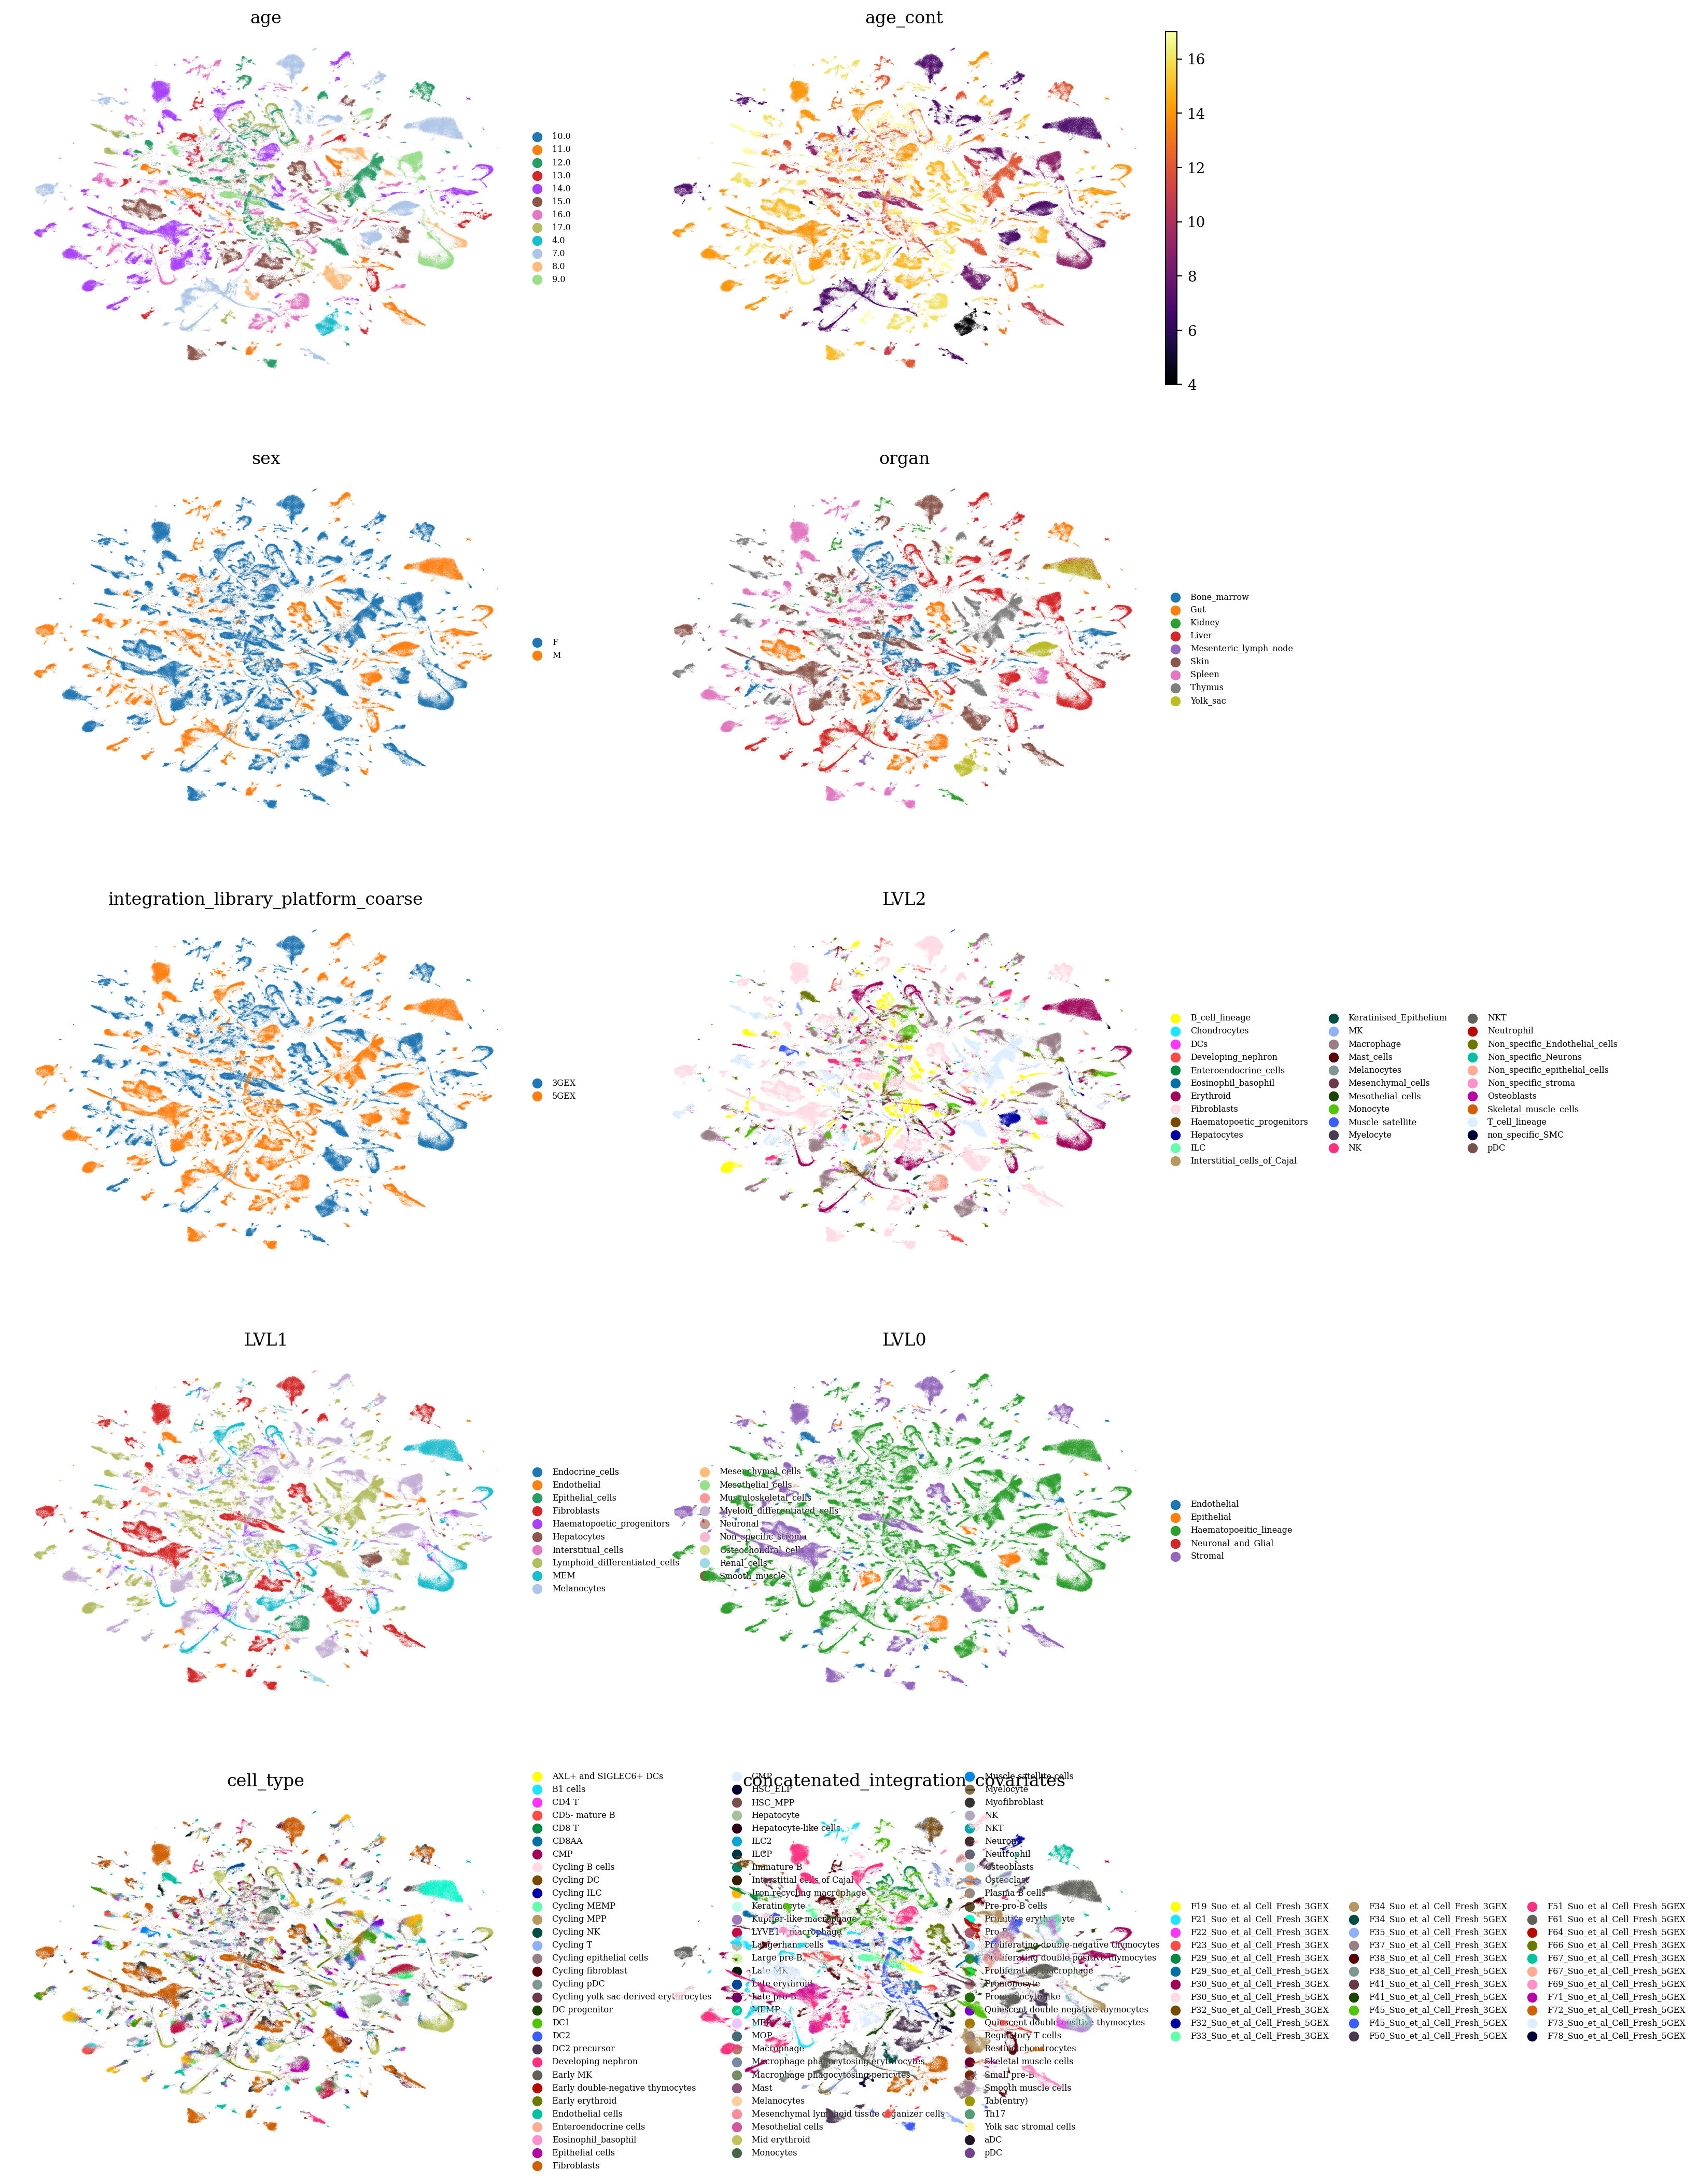

In [14]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent,
        color=[
            "age",
            "age_cont",
            "sex",
            "organ",
            "integration_library_platform_coarse",
            "LVL2",
            "LVL1",
            "LVL0",
            "cell_type",
            "concatenated_integration_covariates",
        ],
        ncols=2,
        color_map="inferno",
        frameon=False,
        legend_fontsize="xx-small",
        show=False,
    )
    plt.show()
    # del latent
    # gc.collect()

In [78]:
torch.Tensor([])

tensor([])